In [1]:
# Importing necessary libraries
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
import torch
import subprocess

# Install ultralytics
subprocess.run(["pip", "install", "ultralytics"])
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.9/802.9 kB 13.5 MB/s eta 0:00:00


In [2]:
# Import wandb and log in
import wandb

# Log in to wandb with API key
wandb.login(key='eb4c4a1fa7eec1ffbabc36420ba1166f797d4ac5')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
# File paths
image_dir = "/kaggle/input/human-faces-object-detection/images"
csv_path = "/kaggle/input/human-faces-object-detection/faces.csv"
output_dir = "/kaggle/output"

In [4]:
# Load the dataset
faces_df = pd.read_csv(csv_path)

In [5]:
# EDA
print(faces_df.head())
print(faces_df.info())
print(faces_df.describe())

     image_name  width  height   x0   y0    x1   y1
0  00001722.jpg   1333    2000  490  320   687  664
1  00001044.jpg   2000    1333  791  119  1200  436
2  00001050.jpg    667    1000  304  155   407  331
3  00001736.jpg    626     417  147   14   519  303
4  00003121.jpg    626     418  462   60   599  166
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3350 entries, 0 to 3349
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  3350 non-null   object
 1   width       3350 non-null   int64 
 2   height      3350 non-null   int64 
 3   x0          3350 non-null   int64 
 4   y0          3350 non-null   int64 
 5   x1          3350 non-null   int64 
 6   y1          3350 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 183.3+ KB
None
             width       height           x0           y0           x1  \
count  3350.000000  3350.000000  3350.000000  3350.000000  3350.000000   
mean    967.96716

In [6]:
# Plot distribution of image widths and heights using Plotly
fig = px.histogram(faces_df, x='width', nbins=50, title='Distribution of Image Widths',
                   labels={'width': 'Image Width'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

fig = px.histogram(faces_df, x='height', nbins=50, title='Distribution of Image Heights',
                   labels={'height': 'Image Height'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

In [7]:
# Plot distribution of bounding box coordinates using Plotly
fig = px.histogram(faces_df, x='x0', nbins=50, title='Distribution of X0 Coordinates',
                   labels={'x0': 'X0 Coordinate'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

fig = px.histogram(faces_df, x='y0', nbins=50, title='Distribution of Y0 Coordinates',
                   labels={'y0': 'Y0 Coordinate'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

fig = px.histogram(faces_df, x='x1', nbins=50, title='Distribution of X1 Coordinates',
                   labels={'x1': 'X1 Coordinate'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

fig = px.histogram(faces_df, x='y1', nbins=50, title='Distribution of Y1 Coordinates',
                   labels={'y1': 'Y1 Coordinate'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

In [8]:
# Convert bounding box coordinates to YOLO format (normalized x_center, y_center, width, height)
def convert_to_yolo(row):
    dw = 1. / row['width']
    dh = 1. / row['height']
    x = (row['x0'] + row['x1']) / 2.0
    y = (row['y0'] + row['y1']) / 2.0
    w = row['x1'] - row['x0']
    h = row['y1'] - row['y0']
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return x, y, w, h

faces_df[['x', 'y', 'w', 'h']] = faces_df.apply(convert_to_yolo, axis=1, result_type='expand')

In [9]:
# Split the dataset into train and validation sets
train_df, val_df = train_test_split(faces_df, test_size=0.2, random_state=42)

In [10]:
# Create YOLO annotation files
annotations_dir = os.path.join(output_dir, 'annotations')
os.makedirs(annotations_dir, exist_ok=True)

for idx, row in faces_df.iterrows():
    annotation_path = os.path.join(annotations_dir, row['image_name'].replace('.jpg', '.txt'))
    with open(annotation_path, 'w') as f:
        f.write(f"0 {row['x']} {row['y']} {row['w']} {row['h']}\n")

In [11]:
# Function to create YOLO annotation files
def create_annotations(df, annotations_dir):
    os.makedirs(annotations_dir, exist_ok=True)
    for idx, row in df.iterrows():
        annotation_path = os.path.join(annotations_dir, row['image_name'].replace('.jpg', '.txt'))
        with open(annotation_path, 'w') as f:
            f.write(f"0 {row['x']} {row['y']} {row['w']} {row['h']}\n")

# Create YOLO annotation files for train and validation sets
train_annotations_dir = os.path.join(output_dir, 'train', 'labels')
val_annotations_dir = os.path.join(output_dir, 'val', 'labels')

create_annotations(train_df, train_annotations_dir)
create_annotations(val_df, val_annotations_dir)

In [12]:
# Image preprocessing
def preprocess_images(image_list, source_dir, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for img_name in image_list:
        img_path = os.path.join(source_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            target_path = os.path.join(target_dir, img_name)
            cv2.imwrite(target_path, img)

train_images_dir = os.path.join(output_dir, 'train', 'images')
val_images_dir = os.path.join(output_dir, 'val', 'images')

preprocess_images(train_df['image_name'].tolist(), image_dir, train_images_dir)
preprocess_images(val_df['image_name'].tolist(), image_dir, val_images_dir)

# Verify annotation files
print("Train annotations sample:")
print(os.listdir(train_annotations_dir)[:5])

print("Validation annotations sample:")
print(os.listdir(val_annotations_dir)[:5])

Train annotations sample:
['00002912.txt', '00001317.txt', '00002680.txt', '00002283.txt', '00001337.txt']
Validation annotations sample:
['00002943.txt', '00000567.txt', '00001646.txt', '00001687.txt', '00002239.txt']


In [13]:
yolo_model = YOLO('yolov8n.yaml') 

In [14]:
# Define the data.yaml file content dynamically
class_names = ['face']
data_yaml_content = f"""
train: {train_images_dir}
val: {val_images_dir}
nc: {len(class_names)}
names: {class_names}
"""

# Save the data.yaml file
data_yaml_path = os.path.join(output_dir, 'data.yaml')
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml_content)

In [15]:
# Train the model
yolo_model.train(data=data_yaml_path, epochs=50, imgsz=640)

Ultralytics YOLOv8.2.60 🚀 Python-3.10.13 torch-2.1.2+cpu CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/kaggle/output/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

100%|██████████| 755k/755k [00:00<00:00, 4.00MB/s]
2024-07-19 09:14:56,986	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-07-19 09:14:57,781	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Currently logged in as: faf2001f (faf2001f-university-of-engineering-and-technology-taxila). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240719_091510-kv96wcuk
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train
wandb: ⭐️ View project at https://wandb.ai/faf2001f-university-of-engineering-and-technology-taxila/YOLOv8
wandb: 🚀 View run at https://wandb.ai/faf2001f-university-of-engineering-and-technology-taxila/YOLOv8/runs/kv96wcuk


Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /kaggle/output/train/labels... 1852 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1852/1852 [00:01<00:00, 1205.96it/s]

train: New cache created: /kaggle/output/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/output/val/labels... 585 images, 0 backgrounds, 0 corrupt: 100%|██████████| 585/585 [00:00<00:00, 1221.75it/s]

val: New cache created: /kaggle/output/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      3.098      3.924      3.886         22        640: 100%|██████████| 116/116 [11:28<00:00,  5.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:05<00:00,  3.47s/it]

                   all        585        585    0.00281      0.207     0.0053     0.0015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      2.772      3.014      3.182         28        640: 100%|██████████| 116/116 [11:30<00:00,  5.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:08<00:00,  3.63s/it]

                   all        585        585     0.0928      0.217     0.0505     0.0163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      2.369      2.471      2.872         20        640: 100%|██████████| 116/116 [11:34<00:00,  5.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:13<00:00,  3.88s/it]

                   all        585        585      0.296      0.491      0.285       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      2.189      2.285      2.714         23        640: 100%|██████████| 116/116 [14:02<00:00,  7.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:15<00:00,  3.95s/it]

                   all        585        585       0.38      0.443      0.348      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      2.044      2.105      2.535         26        640: 100%|██████████| 116/116 [13:09<00:00,  6.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:13<00:00,  3.84s/it]

                   all        585        585      0.365      0.511      0.366      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.907      2.049      2.409         19        640: 100%|██████████| 116/116 [12:39<00:00,  6.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:12<00:00,  3.82s/it]

                   all        585        585      0.365      0.537       0.39      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.818      1.926      2.355         23        640: 100%|██████████| 116/116 [12:34<00:00,  6.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:10<00:00,  3.73s/it]

                   all        585        585      0.376      0.544      0.393       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.739      1.882      2.282         21        640: 100%|██████████| 116/116 [12:56<00:00,  6.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:09<00:00,  3.64s/it]

                   all        585        585      0.415      0.518      0.422      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.668      1.837      2.218         24        640: 100%|██████████| 116/116 [12:38<00:00,  6.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:07<00:00,  3.53s/it]

                   all        585        585      0.378      0.622       0.43      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.623      1.761      2.178         26        640: 100%|██████████| 116/116 [12:52<00:00,  6.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:09<00:00,  3.66s/it]

                   all        585        585      0.376      0.607      0.429       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.586      1.718      2.141         30        640: 100%|██████████| 116/116 [12:27<00:00,  6.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:09<00:00,  3.67s/it]

                   all        585        585      0.467      0.593      0.513       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.539      1.673       2.09         25        640: 100%|██████████| 116/116 [12:28<00:00,  6.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:08<00:00,  3.59s/it]

                   all        585        585      0.485       0.59      0.525      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.503      1.652      2.049         26        640: 100%|██████████| 116/116 [12:03<00:00,  6.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:08<00:00,  3.58s/it]

                   all        585        585      0.475      0.576      0.481      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.501      1.663      2.044         21        640: 100%|██████████| 116/116 [12:18<00:00,  6.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:09<00:00,  3.68s/it]

                   all        585        585      0.461      0.595      0.501      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.478       1.61      2.025         22        640: 100%|██████████| 116/116 [12:20<00:00,  6.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:07<00:00,  3.56s/it]

                   all        585        585      0.507      0.598      0.556       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.441      1.569      1.997         22        640: 100%|██████████| 116/116 [12:34<00:00,  6.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:07<00:00,  3.53s/it]

                   all        585        585      0.453      0.605      0.505       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.435      1.539      1.976         24        640: 100%|██████████| 116/116 [12:08<00:00,  6.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:06<00:00,  3.51s/it]

                   all        585        585      0.498      0.583      0.536      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.409      1.529      1.946         22        640: 100%|██████████| 116/116 [11:45<00:00,  6.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:06<00:00,  3.49s/it]

                   all        585        585       0.48       0.66      0.548       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.403        1.5      1.949         18        640: 100%|██████████| 116/116 [11:50<00:00,  6.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:06<00:00,  3.52s/it]

                   all        585        585      0.577      0.572        0.6      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G       1.37       1.46       1.93         27        640: 100%|██████████| 116/116 [12:28<00:00,  6.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:10<00:00,  3.69s/it]

                   all        585        585      0.472      0.622      0.511      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.375      1.428      1.902         24        640: 100%|██████████| 116/116 [12:41<00:00,  6.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:10<00:00,  3.70s/it]

                   all        585        585      0.493      0.631      0.564      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G       1.37      1.468      1.906         29        640: 100%|██████████| 116/116 [12:33<00:00,  6.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:09<00:00,  3.67s/it]

                   all        585        585      0.573      0.605      0.599      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.326      1.411      1.867         31        640: 100%|██████████| 116/116 [12:25<00:00,  6.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:06<00:00,  3.51s/it]

                   all        585        585      0.563        0.6       0.62      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.311      1.381      1.851         23        640: 100%|██████████| 116/116 [11:57<00:00,  6.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:06<00:00,  3.48s/it]

                   all        585        585      0.608      0.574      0.604      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.285      1.341      1.836         24        640: 100%|██████████| 116/116 [12:38<00:00,  6.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:07<00:00,  3.53s/it]

                   all        585        585      0.542      0.648      0.645      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.285      1.355      1.838         25        640: 100%|██████████| 116/116 [11:53<00:00,  6.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:10<00:00,  3.71s/it]

                   all        585        585      0.529      0.631      0.614      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.287      1.364       1.81         22        640: 100%|██████████| 116/116 [11:59<00:00,  6.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:06<00:00,  3.48s/it]

                   all        585        585      0.602      0.583      0.622      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.287      1.338      1.822         25        640: 100%|██████████| 116/116 [11:32<00:00,  5.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:09<00:00,  3.65s/it]

                   all        585        585      0.521      0.624      0.583      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.237      1.287      1.769         25        640: 100%|██████████| 116/116 [12:39<00:00,  6.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:08<00:00,  3.61s/it]

                   all        585        585      0.525      0.628      0.604       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.252      1.289      1.793         24        640: 100%|██████████| 116/116 [12:44<00:00,  6.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:10<00:00,  3.69s/it]

                   all        585        585      0.606      0.609      0.649      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.231      1.293      1.772         23        640: 100%|██████████| 116/116 [12:53<00:00,  6.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:09<00:00,  3.65s/it]

                   all        585        585      0.559      0.627       0.65      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.225      1.261      1.757         22        640: 100%|██████████| 116/116 [12:25<00:00,  6.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:08<00:00,  3.59s/it]

                   all        585        585      0.584      0.603       0.65      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.198      1.229      1.741         26        640: 100%|██████████| 116/116 [12:05<00:00,  6.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:08<00:00,  3.62s/it]

                   all        585        585      0.624      0.646      0.681      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.193      1.207      1.726         28        640: 100%|██████████| 116/116 [12:23<00:00,  6.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:09<00:00,  3.64s/it]

                   all        585        585      0.594      0.607      0.626      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.189      1.219      1.734         24        640: 100%|██████████| 116/116 [11:57<00:00,  6.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:08<00:00,  3.60s/it]

                   all        585        585      0.646      0.578      0.687      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G       1.19      1.206      1.715         19        640: 100%|██████████| 116/116 [12:33<00:00,  6.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:08<00:00,  3.60s/it]

                   all        585        585       0.63      0.601      0.669      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.187      1.229      1.734         28        640: 100%|██████████| 116/116 [11:46<00:00,  6.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:05<00:00,  3.45s/it]

                   all        585        585      0.587      0.643      0.667      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.162      1.196      1.705         28        640: 100%|██████████| 116/116 [11:33<00:00,  5.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:04<00:00,  3.38s/it]

                   all        585        585      0.695      0.607      0.724      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.162       1.17      1.712         23        640: 100%|██████████| 116/116 [12:10<00:00,  6.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:05<00:00,  3.43s/it]

                   all        585        585      0.656      0.623       0.71      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G       1.17      1.184      1.706         29        640: 100%|██████████| 116/116 [11:29<00:00,  5.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:05<00:00,  3.43s/it]

                   all        585        585      0.736      0.585      0.713      0.488


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.014     0.9397      1.646         12        640: 100%|██████████| 116/116 [11:46<00:00,  6.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:03<00:00,  3.35s/it]

                   all        585        585      0.735      0.588      0.744      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.9768     0.8622      1.624         12        640: 100%|██████████| 116/116 [12:14<00:00,  6.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:08<00:00,  3.63s/it]

                   all        585        585      0.673      0.634      0.728      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.9712     0.8535      1.621         12        640: 100%|██████████| 116/116 [12:38<00:00,  6.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:07<00:00,  3.57s/it]

                   all        585        585      0.719      0.573      0.727      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      0.963     0.8355      1.619         12        640: 100%|██████████| 116/116 [12:14<00:00,  6.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:06<00:00,  3.50s/it]

                   all        585        585      0.684      0.618      0.742      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      0.949     0.8194      1.601         12        640: 100%|██████████| 116/116 [12:25<00:00,  6.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:05<00:00,  3.43s/it]

                   all        585        585      0.748      0.593      0.759      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.9325     0.8027      1.562         12        640: 100%|██████████| 116/116 [11:56<00:00,  6.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:10<00:00,  3.70s/it]

                   all        585        585      0.745      0.617      0.778       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.9282     0.8053      1.564         12        640: 100%|██████████| 116/116 [12:14<00:00,  6.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:10<00:00,  3.69s/it]

                   all        585        585      0.786      0.573      0.769      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.9174     0.7893      1.547         12        640: 100%|██████████| 116/116 [12:00<00:00,  6.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:11<00:00,  3.75s/it]

                   all        585        585      0.755      0.615      0.772       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      0.912     0.7833      1.549         12        640: 100%|██████████| 116/116 [12:14<00:00,  6.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:08<00:00,  3.61s/it]

                   all        585        585      0.765      0.593      0.772      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.8909      0.768      1.535         12        640: 100%|██████████| 116/116 [12:12<00:00,  6.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:05<00:00,  3.44s/it]

                   all        585        585      0.788      0.586      0.777      0.545



50 epochs completed in 11.203 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.60 🚀 Python-3.10.13 torch-2.1.2+cpu CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:01<00:00,  3.26s/it]


                   all        585        585      0.744      0.617      0.778       0.55
Speed: 2.1ms preprocess, 89.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▁▄▄▄▅▅▅▆▆▅▅▆▆▆▆▆▆▇▆▇▇▆▆▇▇▇▇▇▇█▇████████
wandb:     metrics/mAP50-95(B) ▁▁▂▃▃▄▄▄▄▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇█████
wandb:    metrics/precision(B) ▁▂▄▄▄▄▅▄▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▇▆▇▆▇▇█▇▇▇████
wandb:       metrics/recall(B) ▁▁▅▅▆▆▆▇▇▇▇▇▇▇█▇█▇▇▇█▇▇█▇▇█▇▇█▇▇▇█▇▇▇▇▇▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▆▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb:          train/cls_loss █▆▅▄▄▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▆▅▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb:            val/box_loss █▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7acff703dc30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 


image 1/1 /kaggle/output/val/images/00001448.jpg: 480x640 1 face, 104.6ms
Speed: 3.8ms preprocess, 104.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


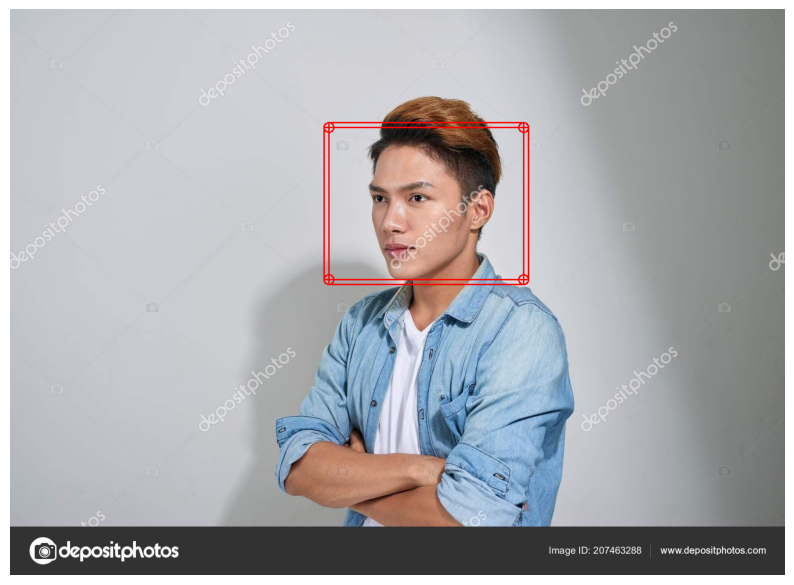


image 1/1 /kaggle/output/val/images/00001275.jpg: 640x544 1 face, 120.0ms
Speed: 3.5ms preprocess, 120.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


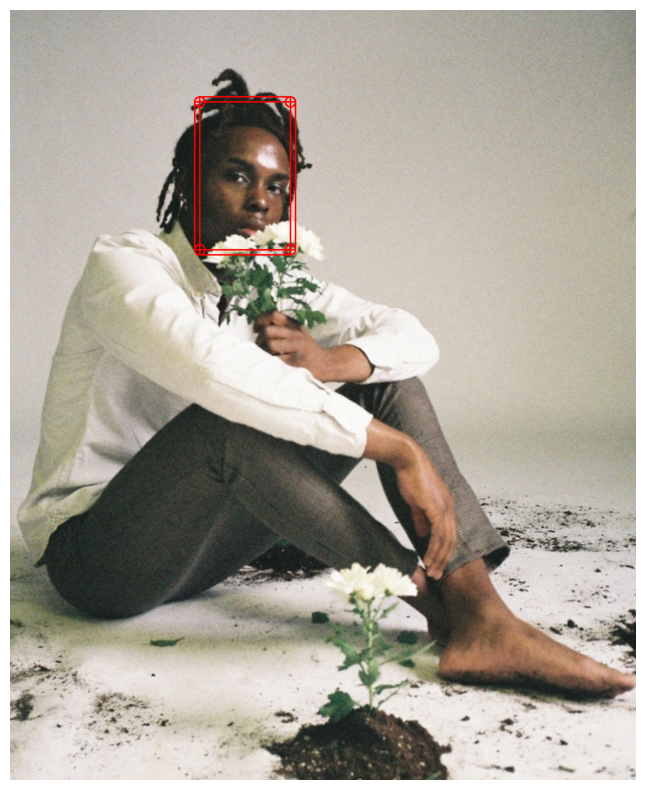


image 1/1 /kaggle/output/val/images/00002619.jpg: 448x640 2 faces, 107.9ms
Speed: 3.1ms preprocess, 107.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


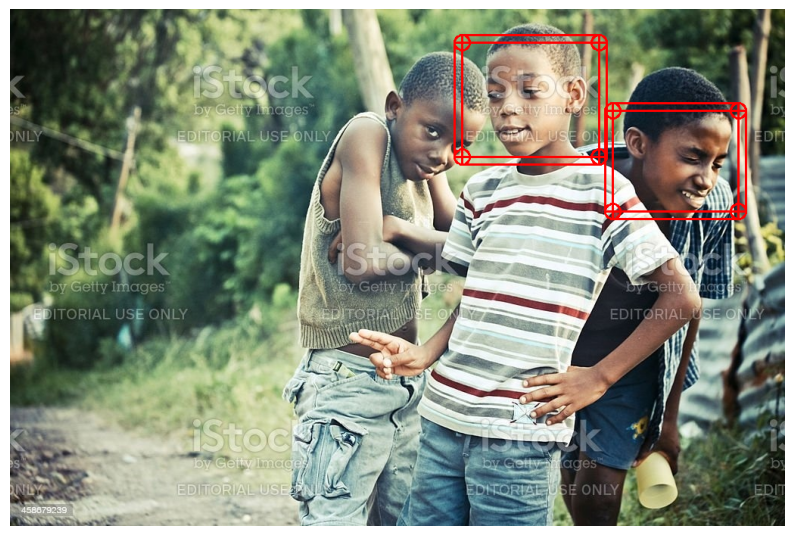


image 1/1 /kaggle/output/val/images/00003288.jpg: 640x512 1 face, 117.0ms
Speed: 3.4ms preprocess, 117.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


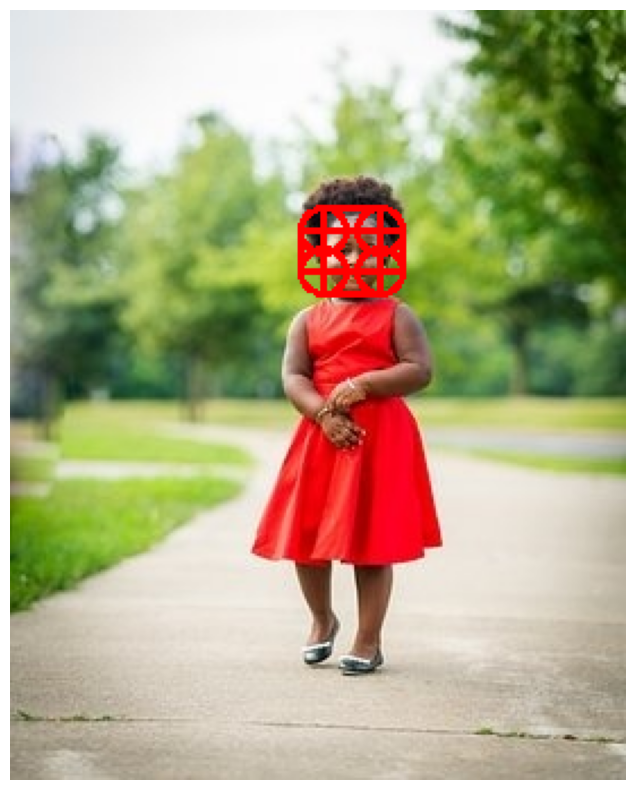


image 1/1 /kaggle/output/val/images/00000597.jpg: 384x640 2 faces, 89.8ms
Speed: 2.6ms preprocess, 89.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


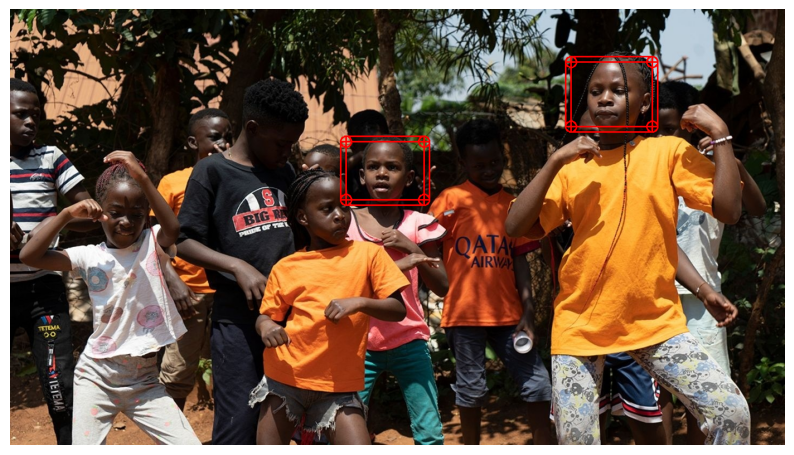


image 1/1 /kaggle/output/val/images/00002923.jpg: 448x640 2 faces, 85.8ms
Speed: 3.5ms preprocess, 85.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


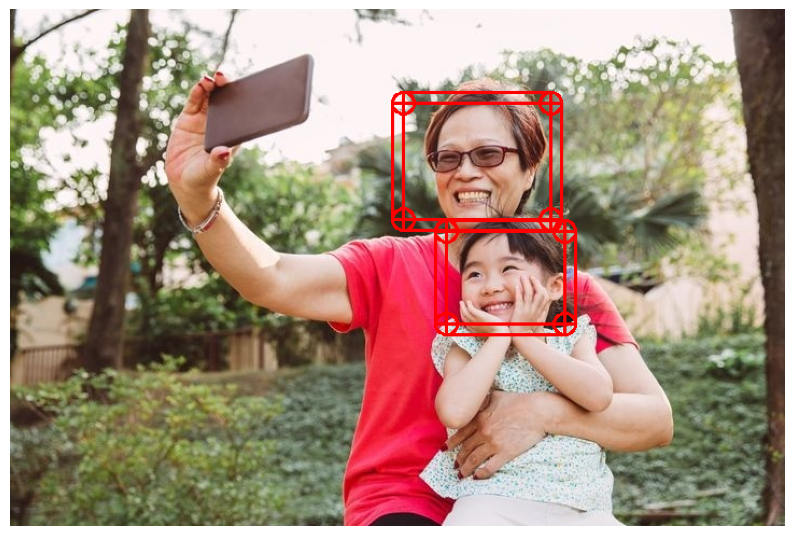


image 1/1 /kaggle/output/val/images/00001368.jpg: 480x640 2 faces, 88.0ms
Speed: 3.0ms preprocess, 88.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


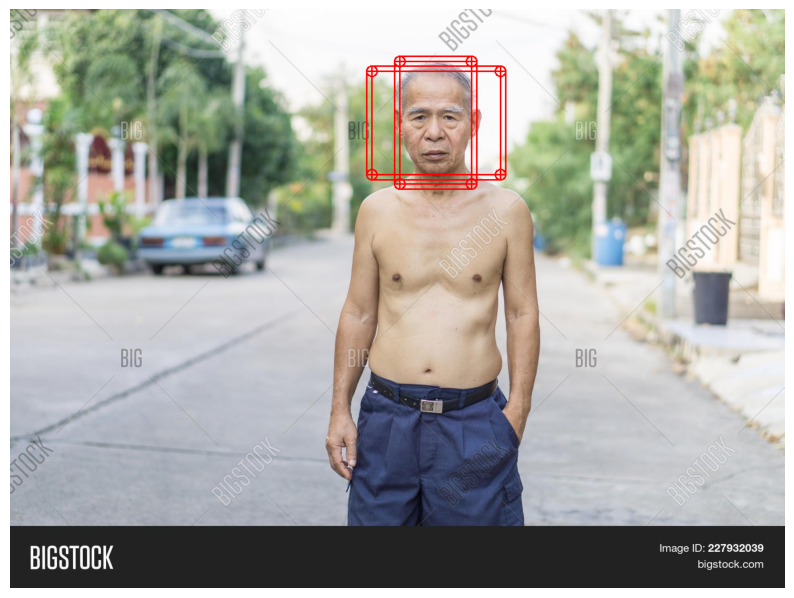


image 1/1 /kaggle/output/val/images/00003027.jpg: 448x640 1 face, 85.3ms
Speed: 3.0ms preprocess, 85.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


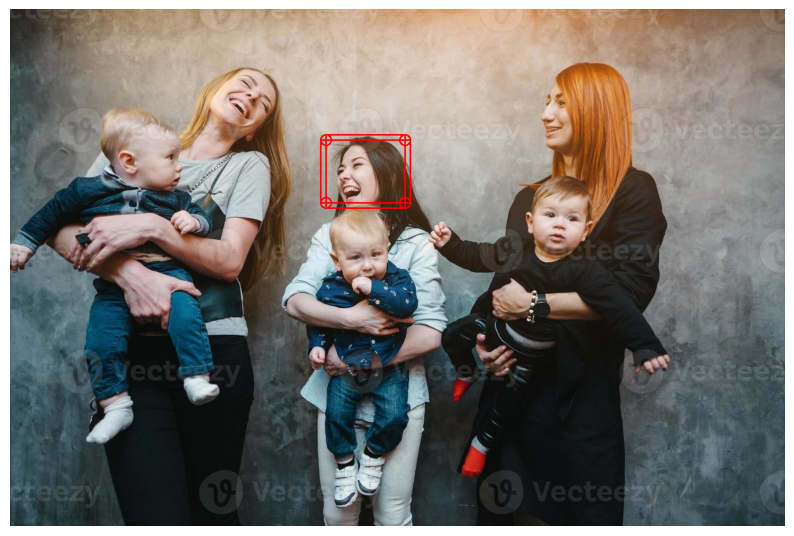


image 1/1 /kaggle/output/val/images/00001990.jpg: 640x448 1 face, 109.5ms
Speed: 2.7ms preprocess, 109.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


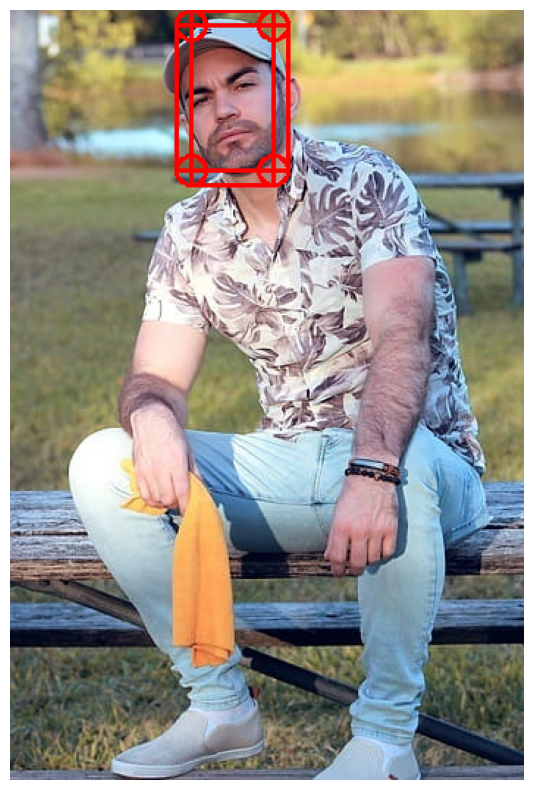


image 1/1 /kaggle/output/val/images/00000231.jpg: 448x640 1 face, 86.7ms
Speed: 3.1ms preprocess, 86.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


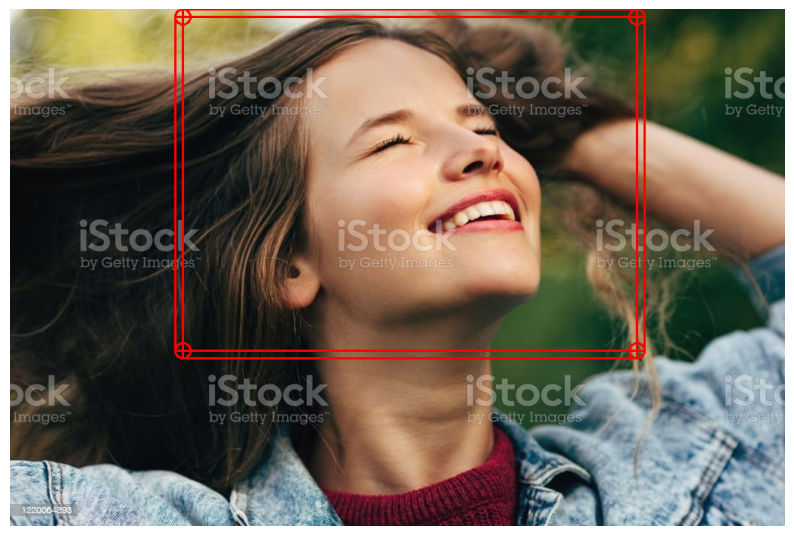

Process completed. Outputs are stored in: /kaggle/output


In [16]:
# Function to draw rounded rectangle
def draw_rounded_rectangle(img, start_point, end_point, color, thickness, radius):
    x1, y1 = start_point
    x2, y2 = end_point
    img = cv2.rectangle(img, (x1 + radius, y1), (x2 - radius, y2), color, thickness)
    img = cv2.rectangle(img, (x1, y1 + radius), (x2, y2 - radius), color, thickness)
    img = cv2.circle(img, (x1 + radius, y1 + radius), radius, color, thickness)
    img = cv2.circle(img, (x2 - radius, y1 + radius), radius, color, thickness)
    img = cv2.circle(img, (x1 + radius, y2 - radius), radius, color, thickness)
    img = cv2.circle(img, (x2 - radius, y2 - radius), radius, color, thickness)
    return img

# Display 10 sample images with detection results
def display_samples_with_detections(model, images_dir, samples=10):
    sample_images = os.listdir(images_dir)[:samples]
    for img_name in sample_images:
        img_path = os.path.join(images_dir, img_name)
        results = model(img_path)[0]  # Get the first (and only) Results object
        img = cv2.imread(img_path)
        for box in results.boxes.xyxy.cpu().numpy():  # x1, y1, x2, y2
            x1, y1, x2, y2 = map(int, box)
            img = draw_rounded_rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2, 10)  # Red color, thickness 2, radius 10
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

display_samples_with_detections(yolo_model, val_images_dir)

print("Process completed. Outputs are stored in:", output_dir)